<img src="https://www.scienze.unimib.it/sites/sc02/files/scientifica_logo_scuola.png" align="left" width="120px" height="138u8i0px">

<h1>Medical Imaging Project: <b>MCI Conversion using MRI</b></h1>

<h4>The aim of this notebook is to show examples of how we can predict MCI conversion using neural networks.</h4>

In [7]:
# Set to False if you are running on local env
GDRIVE = True

# Set the path of your data folder (ex: {DATA_PATH}/MCI/MR)
DATA_PATH = "/content/drive/MyDrive/Progetto Medical Imaging/Data"

# Set to True if you want to preprocess data again
FIRST_RUN = False

# Set to True if you want to retrain all the models
TRAIN = False

# **Setup**: Import Libraries, Read MRI Data

## Import Libraries

In [2]:
%%capture
! pip install nibabel
! pip install opencv-python
! pip install scikit-learn
! pip install numpy==1.24.1
! pip install torchinfo

In [3]:
%%capture
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import glob
import pickle
import nibabel as nib
from scipy import ndimage

# Image directory management
import cv2 as cv
import os
from sklearn.model_selection import train_test_split

# Models
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import DatasetFolder
from torch import nn
from torch.optim.lr_scheduler import CosineAnnealingLR

from torchinfo import summary

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(0)

## Read MRI Data

In [8]:
if GDRIVE:
  from google.colab import drive
  drive.mount("/content/drive")

Mounted at /content/drive


In [9]:
print(f"Data is located at: {DATA_PATH}")

Data is located at: /content/drive/MyDrive/Progetto Medical Imaging/Data


Read MRI Data, Masks, and check files

In [10]:
df = pd.read_csv(os.path.join(*[DATA_PATH, "MCI_conversion.csv"]))
masks = nib.load(os.path.join(*[DATA_PATH, "rmask_ICV.nii"])).get_fdata()
subjects = list(map((lambda x: "w"+x+".nii.gz"), df["Subject"]))
mr_files = list(map((lambda x: x[60:]),
                    glob.glob(os.path.join(*[DATA_PATH, "MCI", "MR", "*"]))))

In [11]:
df["has_file"] = df["Subject"].apply(lambda x: True if f"w{x}.nii.gz" in mr_files else False)
df["ttc"] = df["TimeToConversion"].str[:-5].astype(int)
df["lvd"] = df["LastVisitDelay"].str[:-5].astype(int)

If the patient has `LastVisitDelay == -1` than we consider it **converted**.

In [12]:
def ground_truth_class(row):
  if row.has_file and row.lvd >= 0:
    return 0 # non converted
  elif row.has_file and row.lvd == -1:
    return 1 # converted
  else:
    return None # no file

df.loc[:, "Converted"] = df.apply(ground_truth_class, axis = 1)

# **EDA**: Explore MRI Data

## **Data**: Num of Subjects, LastVisitDelay, TimeToConversion

In [41]:
df.columns

Index(['idx', 'Subject', 'LastVisitDelay', 'TimeToConversion', 'has_file',
       'ttc', 'lvd', 'Converted'],
      dtype='object')

In [42]:
df.isnull().values.any()

True

In [43]:
# Total number of patients
len(df)

273

**Subject**

In [44]:
df.Subject.nunique()

273

**LastVisitDelay**

In [45]:
lvd = df["LastVisitDelay"].str[:-5].astype(int)

In [46]:
# Number of converted patients
lvd[lvd == -1].count()

36

In [47]:
# Number of patients that skipped FUP
lvd[lvd < -1].count()

16

In [48]:
# Number of non converted patients
lvd[lvd >= 0].count()

221

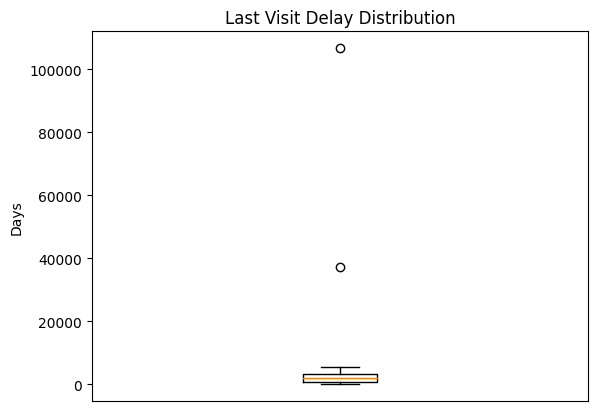

In [49]:
# Outliers check
plt.boxplot(lvd[lvd >= 0].to_list())
plt.xticks([], [])
plt.ylabel("Days")
plt.title("Last Visit Delay Distribution")
plt.show()

In [50]:
# Check outlier subjects
idxs = df[df["lvd"] >= 20000].index
df[df["lvd"] >= 20000]

idx     Subject LastVisitDelay TimeToConversion  has_file  ttc     lvd  \
68    68  023_S_2068    106750 days          -1 days      True   -1  106750   
100  100  041_S_1418     37269 days          -1 days     False   -1   37269   

     Converted  
68         0.0  
100        NaN

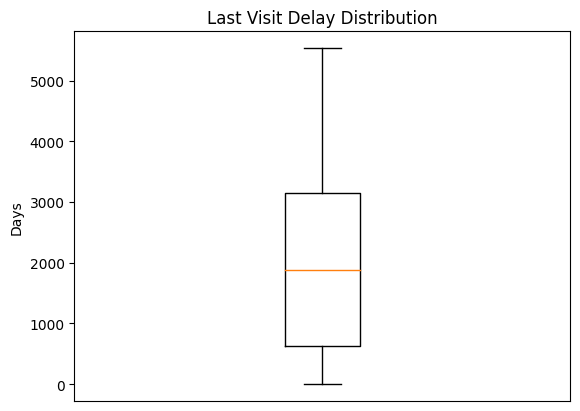

In [51]:
temp = df.drop(idxs)["lvd"]
plt.boxplot(temp[temp >= 0].to_list())
plt.xticks([], [])
plt.ylabel("Days")
plt.title("Last Visit Delay Distribution")
plt.show()

**TimeToConversion**

In [52]:
ttc = df["TimeToConversion"].str[:-5].astype(int)

In [53]:
# Number of converted patients
ttc[ttc >= 0].count()

34

In [54]:
# Number of non converted patients
ttc[ttc < 0].count()

239

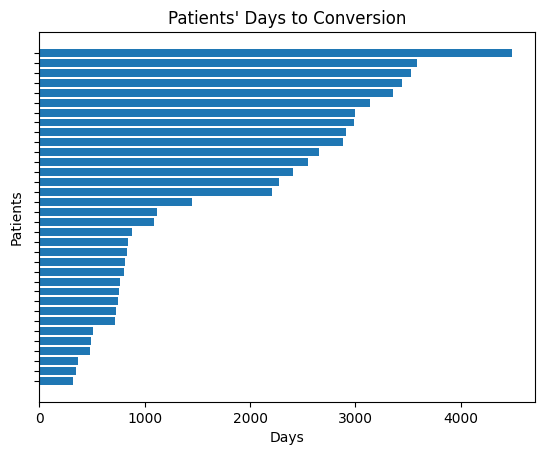

In [55]:
plt.barh(np.arange(1, len(ttc[ttc >= 0])+1), ttc[ttc >= 0].sort_values(), align='center')
plt.yticks(np.arange(1, len(ttc[ttc >= 0])+1), [])
plt.xlabel("Days")
plt.ylabel("Patients")
plt.title("Patients' Days to Conversion")
plt.show()

**Incongruence in converted/not**

In [56]:
set_ttc_converted = set(df[df["ttc"] >= 0]["Subject"])
set_lvd_converted = set(df[df["lvd"] == -1]["Subject"])

In [57]:
set_ttc_converted.symmetric_difference(set_lvd_converted)

{'002_S_6695', '123_S_6884'}

In [58]:
df[df["Subject"] == "002_S_6695"]

idx     Subject LastVisitDelay TimeToConversion  has_file  ttc  lvd  \
191  191  002_S_6695        -1 days          -1 days      True   -1   -1   

     Converted  
191        1.0

In [59]:
df[df["Subject"] == "123_S_6884"]

idx     Subject LastVisitDelay TimeToConversion  has_file  ttc  lvd  \
239  239  123_S_6884        -1 days          -1 days      True   -1   -1   

     Converted  
239        1.0

## **Find Match**: How many subjects have a corresponding MRI?

In [60]:
# Files in Subjects AND MRI files
len(set.intersection(set(subjects), set(mr_files)))

64

In [61]:
df["has_file"] = df["Subject"].apply(lambda x: True if f"w{x}.nii.gz" in mr_files else False)

In [62]:
# Converted existing files based on TimeToConversion value
len(df[(df["has_file"]) & (df["ttc"] >= 0)])

13

In [63]:
# Non converted existing files based on TimeToConversion value
len(df[(df["has_file"]) & (df["ttc"] < 0)])

51

In [64]:
# Converted existing files based on LastVisitDelay value
len(df[(df["has_file"]) & (df["lvd"] == -1)])

15

In [65]:
# Non converted existing files based on LastVisitDelay value
len(df[(df["has_file"]) & (df["lvd"] >= 0)])

33

In [66]:
# Skipped FUP existing files based on LastVisitDelay value
len(df[(df["has_file"]) & (df["lvd"] < -1)])

16

## **Explore MRI**: Shape, MRI Example

In [67]:
s = [DATA_PATH, "MCI", "MR", mr_files[0]]
image_3d = nib.load(os.path.join(*s)).get_fdata()

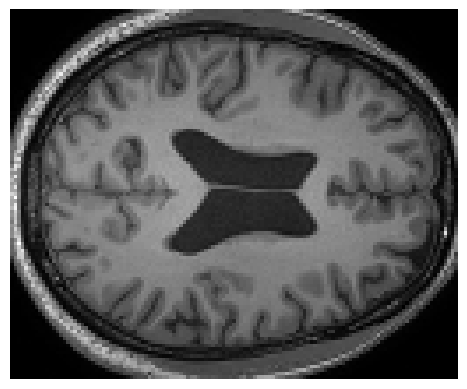

In [68]:
image_3d = nib.load(
    os.path.join(*[DATA_PATH, "MCI", "MR", mr_files[4]])).get_fdata()
plt.imshow(image_3d[:,:,60], cmap="gray")
plt.axis("off")
plt.show()

## **Explore Masks**

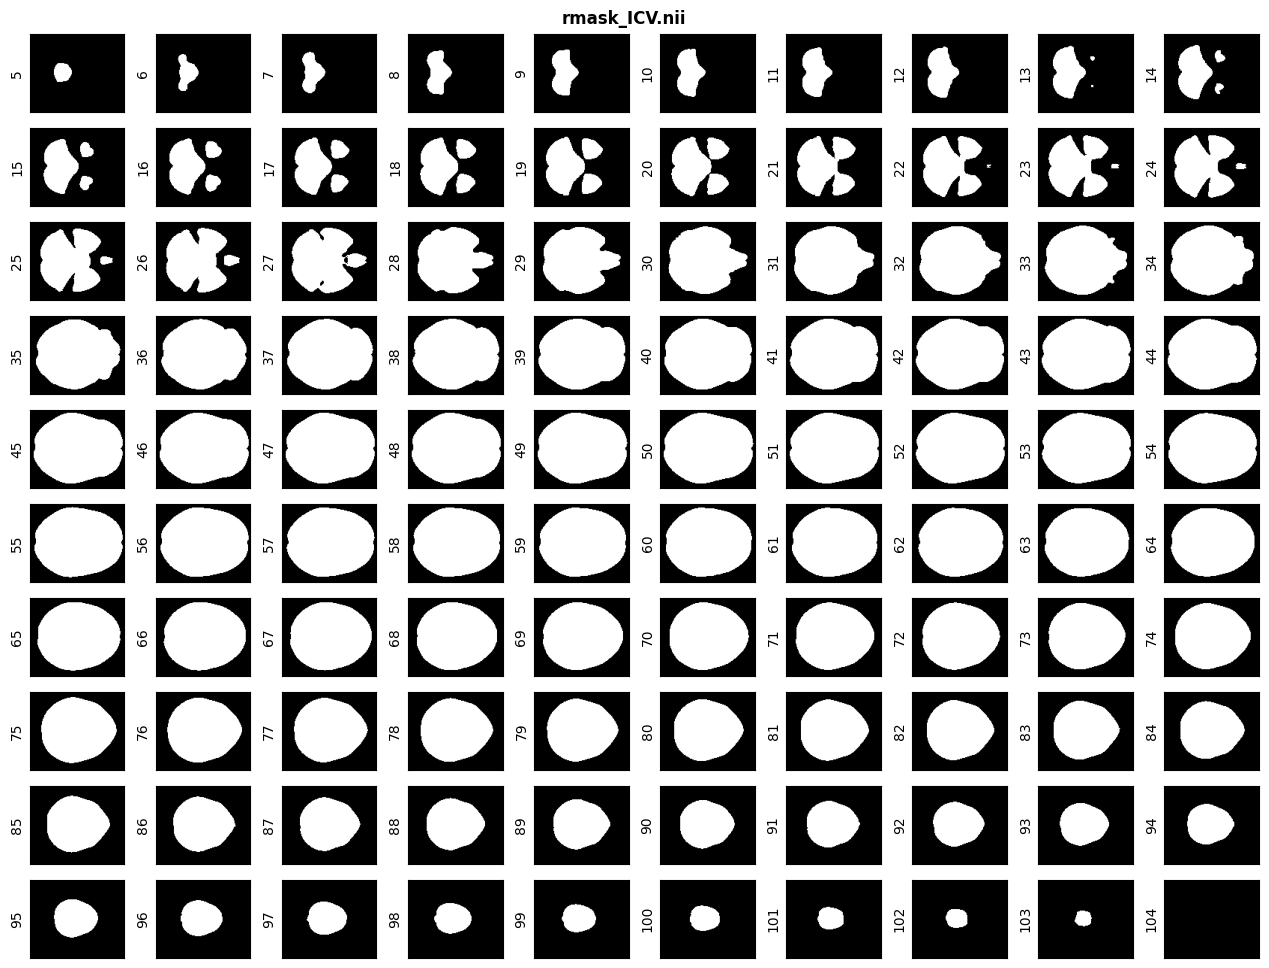

In [69]:
# File rmask_ICV.nii
rmask = nib.load(os.path.join(*[DATA_PATH, "rmask_ICV.nii"]))
im = rmask.get_fdata()

plt.figure(figsize=(16, 12))
plt.suptitle("rmask_ICV.nii", y=0.9, fontweight="bold")
for idx, i in enumerate(np.arange(5, 105)):
  plt.subplot(10, 10, idx+1)
  plt.xticks([], [])
  plt.yticks([], [])
  plt.ylabel(i)
  plt.imshow(im[:,:,i], cmap="gray")

## **Masks on Image**: Sagittal, Coronal, and Axial

In [70]:
# Read mask
mask = nib.load(os.path.join(*[DATA_PATH, "rmask_ICV.nii"]))
mask_3d = mask.get_fdata()
mask_cmap = ListedColormap([(0,0,0,0), "red"])

# Read image
image_3d = nib.load(
    os.path.join(*[DATA_PATH, "MCI", "MR", mr_files[0]])).get_fdata()

### **Sagittal**

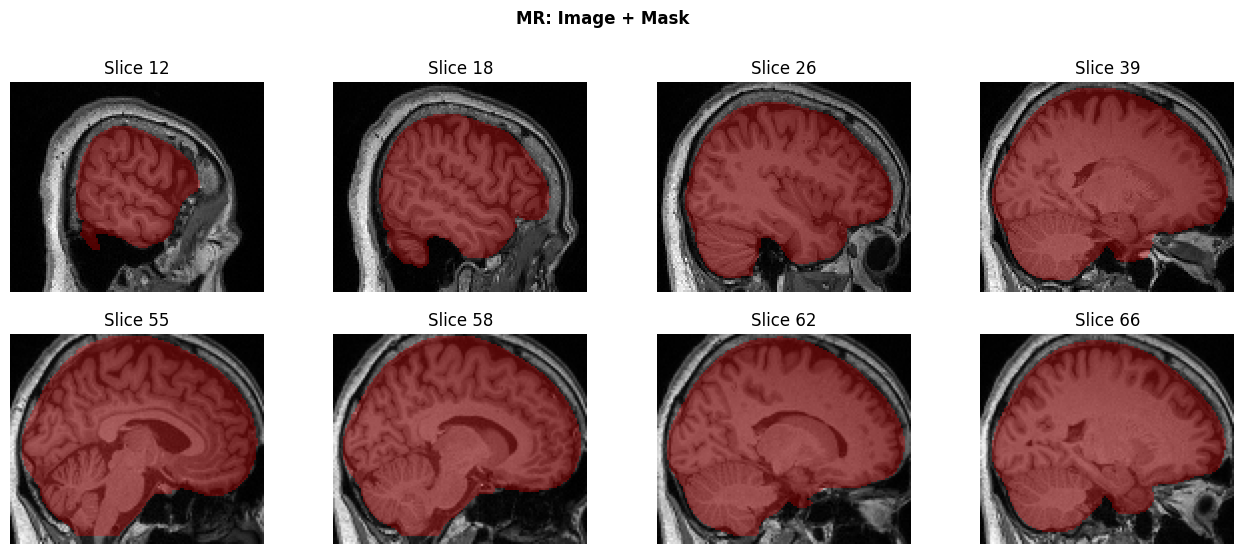

In [71]:
idxs = [12, 18, 26, 39, 55, 58, 62, 66]
plt.figure(figsize=(16,6))
plt.suptitle("MR: Image + Mask", y=1, fontweight="bold")
for i, slice_idx in enumerate(idxs):
  plt.subplot(2,4,i+1)
  plt.axis("off")
  plt.title(f"Slice {slice_idx}")
  img = ndimage.rotate(image_3d[slice_idx,:,:], 90)
  msk = ndimage.rotate(mask_3d[slice_idx,:,:], 90)
  plt.imshow(img, cmap="gray")
  plt.imshow(msk, cmap=mask_cmap, alpha=0.3)

### **Coronal**

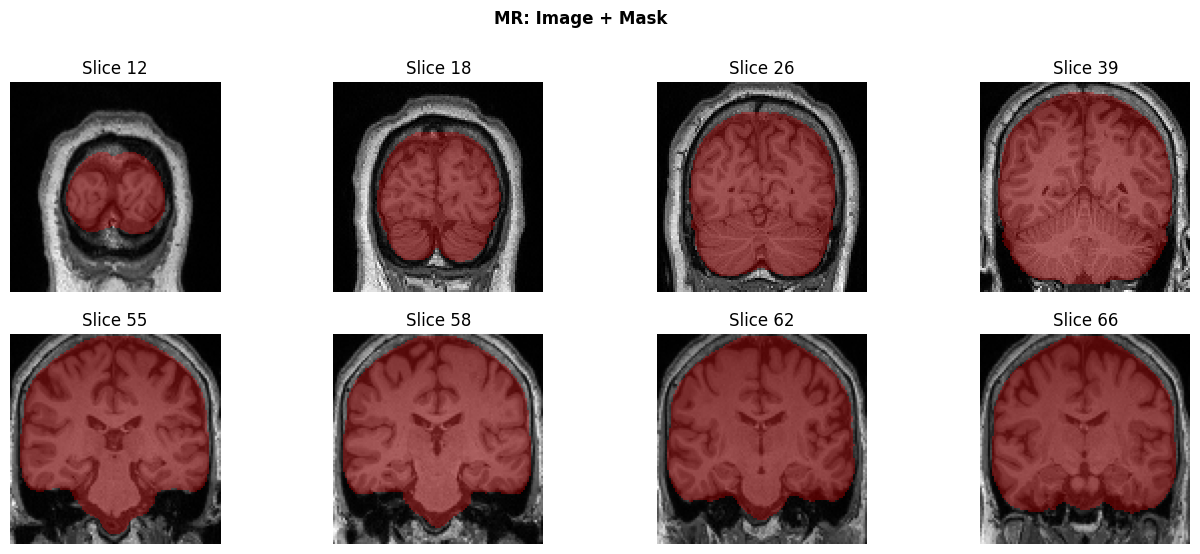

In [72]:
idxs = [12, 18, 26, 39, 55, 58, 62, 66]
plt.figure(figsize=(16,6))
plt.suptitle("MR: Image + Mask", y=1, fontweight="bold")
for i, slice_idx in enumerate(idxs):
  plt.subplot(2,4,i+1)
  plt.axis("off")
  plt.title(f"Slice {slice_idx}")
  img = ndimage.rotate(image_3d[:,slice_idx,:], 90)
  msk = ndimage.rotate(mask_3d[:,slice_idx,:], 90)
  plt.imshow(img, cmap="gray")
  plt.imshow(msk, cmap=mask_cmap, alpha=0.3)

### **Axial**

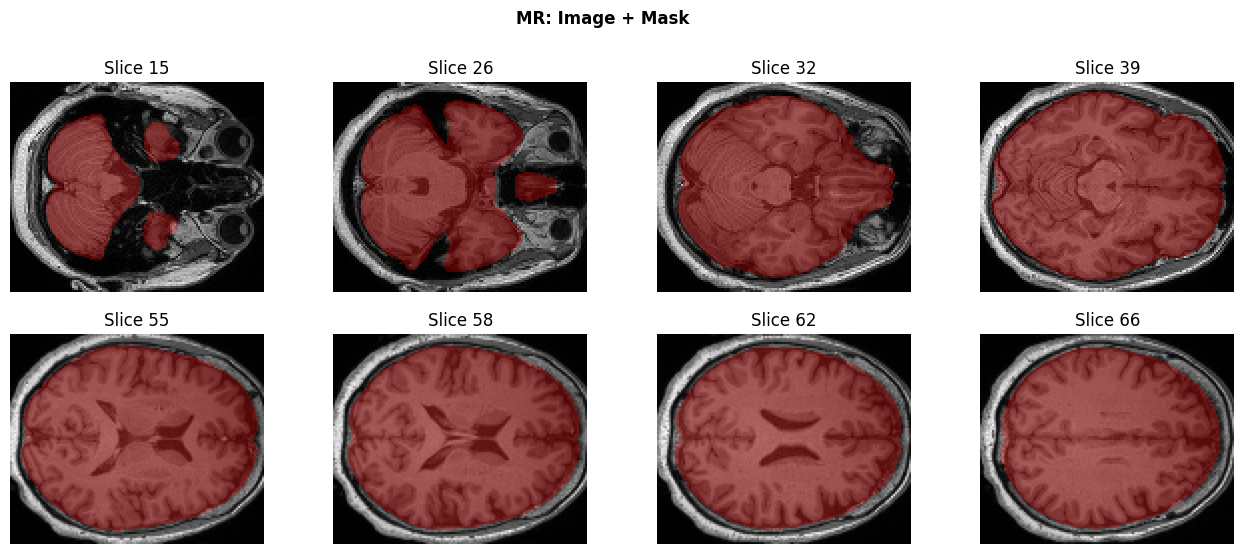

In [73]:
idxs = [15, 26, 32, 39, 55, 58, 62, 66]
plt.figure(figsize=(16,6))
plt.suptitle("MR: Image + Mask", y=1, fontweight="bold")
for i, slice_idx in enumerate(idxs):
  plt.subplot(2,4,i+1)
  plt.axis("off")
  plt.title(f"Slice {slice_idx}")
  plt.imshow(image_3d[:,:,slice_idx], cmap="gray")
  plt.imshow(mask_3d[:,:,slice_idx], cmap=mask_cmap, alpha=0.3)

## **Converted** vs **Not Converted**: Comparison

In [74]:
pt_conv = df[(df["has_file"]) & (df["lvd"] == -1)].sample()["Subject"].item()
pt_non_conv = df[(df["has_file"]) & (df["lvd"] >= 0)].sample()["Subject"].item()

In [75]:
conv_3d = nib.load(
    os.path.join(*[DATA_PATH, "MCI", "MR", f"w{pt_conv}.nii.gz"])).get_fdata()
non_conv_3d = nib.load(
    os.path.join(*[DATA_PATH, "MCI", "MR", f"w{pt_non_conv}.nii.gz"])).get_fdata()

In [76]:
def get_contours(im, ms):
  binary_ms = ms.astype("uint8")
  con, _ = cv.findContours(binary_ms, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  m = np.zeros(im.shape, np.uint8)
  contours = cv.drawContours(m, con, -1, (255), 1)
  return contours

### **Axial**

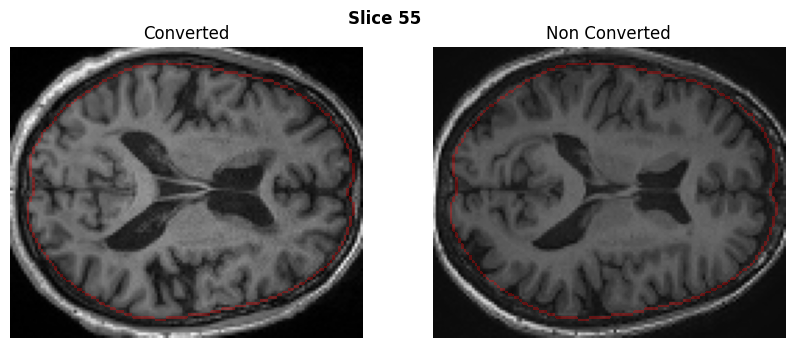

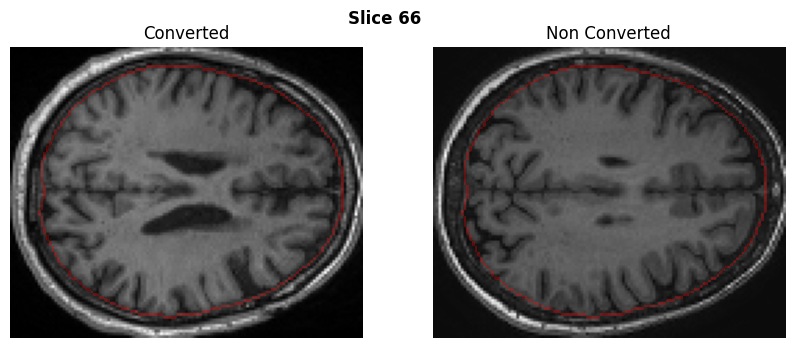

In [77]:
for slice_idx in [55, 66]:

  cont = get_contours(conv_3d[:,:,slice_idx], mask_3d[:,:,slice_idx])
  cont_non = get_contours(non_conv_3d[:,:,slice_idx], mask_3d[:,:,slice_idx])

  plt.figure(figsize=(10, 6))

  # Converted
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Converted")
  plt.imshow(conv_3d[:,:,slice_idx], cmap="gray")
  plt.imshow(cont, cmap=mask_cmap, alpha=0.3)

  # Non Converted
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Non Converted")
  plt.imshow(non_conv_3d[:,:,slice_idx], cmap="gray")
  plt.imshow(cont_non, cmap=mask_cmap, alpha=0.3)

  plt.suptitle(f"Slice {slice_idx}", fontweight="bold", y=0.8)
  plt.show()

### **Sagittal**


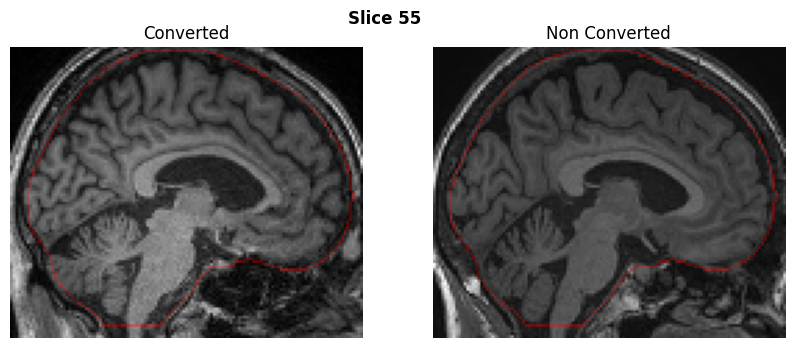

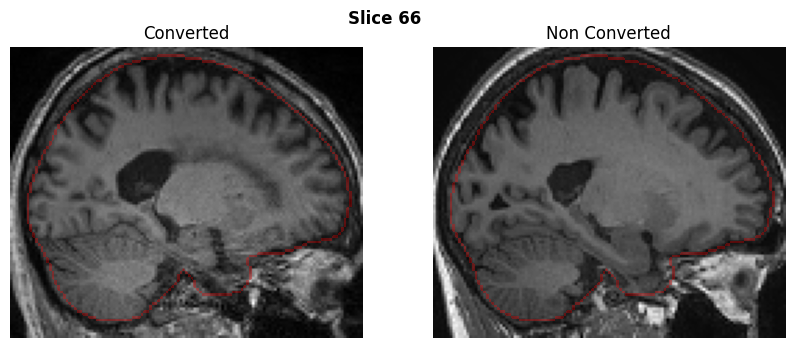

In [78]:
for slice_idx in [55, 66]:

  cont = get_contours(conv_3d[slice_idx,:,:], mask_3d[slice_idx,:,:])
  cont_non = get_contours(non_conv_3d[slice_idx,:,:], mask_3d[slice_idx,:,:])

  plt.figure(figsize=(10, 6))

  # Converted
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Converted")
  plt.imshow(ndimage.rotate(conv_3d[slice_idx,:,:], 90), cmap="gray")
  plt.imshow(ndimage.rotate(cont, 90), cmap=mask_cmap, alpha=0.3)

  # Non Converted
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Non Converted")
  plt.imshow(ndimage.rotate(non_conv_3d[slice_idx,:,:], 90), cmap="gray")
  plt.imshow(ndimage.rotate(cont_non, 90), cmap=mask_cmap, alpha=0.3)

  plt.suptitle(f"Slice {slice_idx}", fontweight="bold", y=0.8)
  plt.show()

### **Coronal**


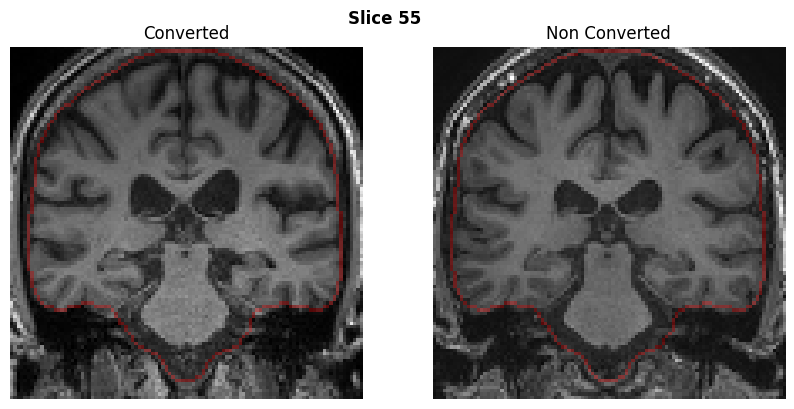

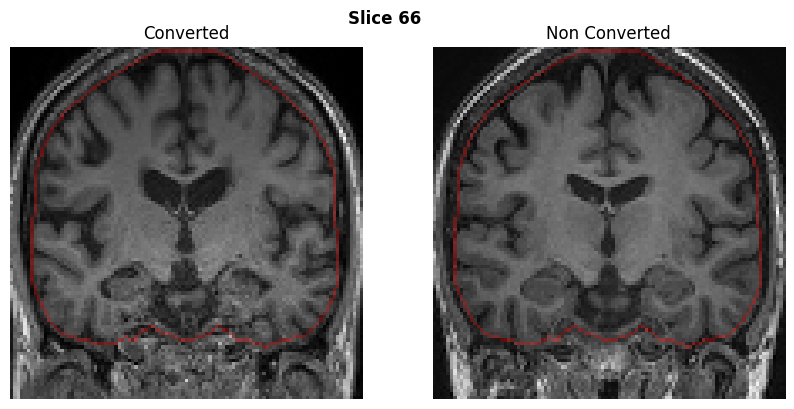

In [79]:
for slice_idx in [55, 66]:

  cont = get_contours(conv_3d[:,slice_idx,:], mask_3d[:,slice_idx,:])
  cont_non = get_contours(non_conv_3d[:,slice_idx,:], mask_3d[:,slice_idx,:])

  plt.figure(figsize=(10, 6))

  # Converted
  plt.subplot(1,2,1)
  plt.axis("off")
  plt.title("Converted")
  plt.imshow(ndimage.rotate(conv_3d[:,slice_idx,:], 90), cmap="gray")
  plt.imshow(ndimage.rotate(cont, 90), cmap=mask_cmap, alpha=0.3)

  # Non Converted
  plt.subplot(1,2,2)
  plt.axis("off")
  plt.title("Non Converted")
  plt.imshow(ndimage.rotate(non_conv_3d[:,slice_idx,:], 90), cmap="gray")
  plt.imshow(ndimage.rotate(cont_non, 90), cmap=mask_cmap, alpha=0.3)

  plt.suptitle(f"Slice {slice_idx}", fontweight="bold", y=0.85)
  plt.show()

## **Converted**: Example

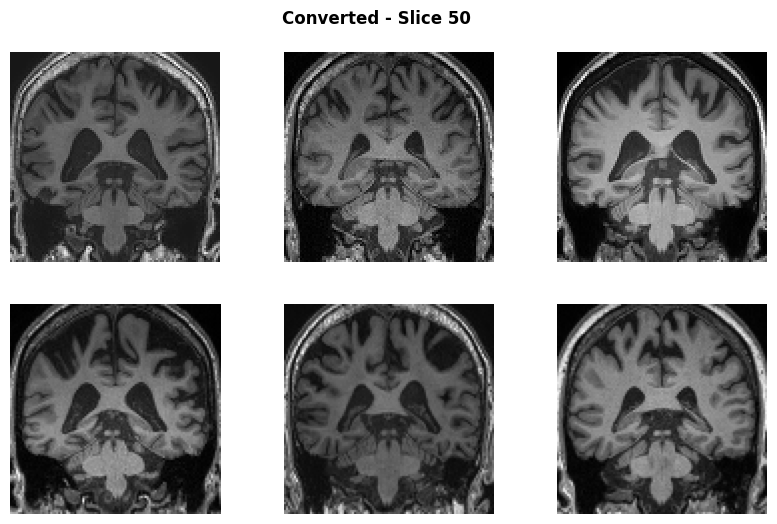

In [80]:
pt_conv = df[(df["has_file"]) & (df["lvd"] == -1)].head(6)["Subject"]

plt.figure(figsize=(10, 6))
plt.suptitle("Converted - Slice 50", fontweight="bold", y=0.95)
for idx, item in enumerate(pt_conv):
  image_3d = nib.load(
      os.path.join(*[DATA_PATH, "MCI", "MR", f"w{item}.nii.gz"])).get_fdata()

  plt.subplot(2,3,idx+1)
  plt.axis("off")
  plt.imshow(ndimage.rotate(image_3d[:,50,:], 90), cmap="gray")

## **Non Converted**: Example

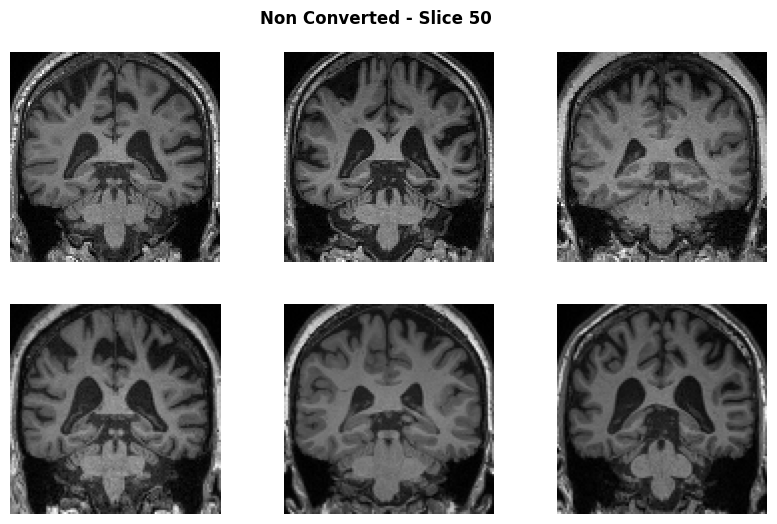

In [81]:
pt_non_conv = df[(df["has_file"]) & (df["lvd"] >= 0)].head(6)["Subject"]

plt.figure(figsize=(10, 6))
plt.suptitle("Non Converted - Slice 50", fontweight="bold", y=0.95)
for idx, item in enumerate(pt_non_conv):
  image_3d = nib.load(
      os.path.join(*[DATA_PATH, "MCI", "MR", f"w{item}.nii.gz"])).get_fdata()

  plt.subplot(2,3,idx+1)
  plt.axis("off")
  plt.imshow(ndimage.rotate(image_3d[:,50,:], 90), cmap="gray")

# **Data Preprocessing**: Normalization, Scaling, Skull-stripping

In [82]:
def compute_intensity_normalization(img_3d):
  """
    Performs intensity normalization on the input MRI data.

    :param img_3d: 3D MRI data
    :returns: 3D MRI data normalized
  """
  num_patients = 1

  int_values = np.zeros((num_patients,), dtype=np.float32)

  l_thr = np.percentile(img_3d, 1) # compute percentile
  int_values = np.percentile(img_3d[img_3d > l_thr], 50)

  int_values = int_values.reshape((1, 1, 1))
  normalized_data = (img_3d - 0.5 * int_values) / int_values

  return normalized_data

In [83]:
def compute_scaling(img_3d):
  """
    Performs scaling into range 0-1.

    :param img_3d: 3D MRI data
    :returns: 3D MRI data scaled
  """
  min = np.min(img_3d)
  max = np.max(img_3d)
  return (img_3d - min) / (max - min)

In [84]:
def compute_skull_stripping(img_3d, slice_idx, plane):
  """
    Performs skull-stripping.

    :param img_3d: 3D MRI data
    :param slice_idx: index of the slice of interest
    :param plane: name of the plane of interest
    :rtype: Union[sagittal, axial, coronal]
    :returns: 3D MRI data normalized
  """
  if plane == "sagittal":
    slice_img = img_3d[slice_idx,:,:].copy()
    slice_msk = masks[slice_idx,:,:].copy()
  elif plane == "coronal":
    slice_img = img_3d[:,slice_idx,:].copy()
    slice_msk = masks[:,slice_idx,:].copy()
  elif plane == "axial":
    slice_img = img_3d[:,:,slice_idx].copy()
    slice_msk = masks[:,:,slice_idx].copy()

  bool_msk = np.ma.masked_where(slice_msk != 0, slice_msk).mask
  stripped = slice_img * bool_msk

  return stripped

## Example with one subject

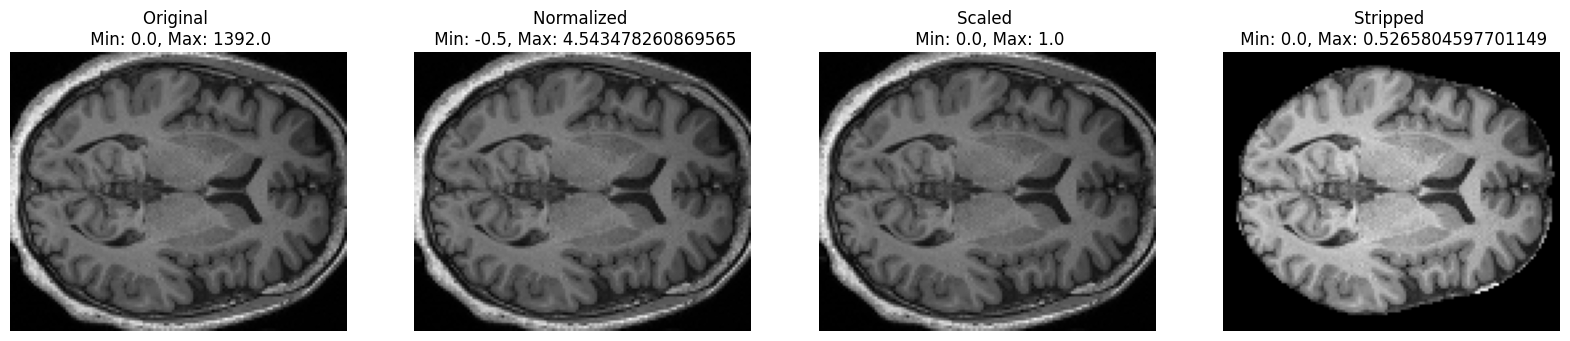

In [85]:
image_3d = nib.load(
    os.path.join(*[DATA_PATH, "MCI", "MR", mr_files[0]])).get_fdata()


plt.figure(figsize=(20,5))
plt.subplot(1, 4, 1)
plt.imshow(image_3d[:,:,50], cmap="gray")
plt.title(f"Original \n Min: {np.min(image_3d)}, Max: {np.max(image_3d)}")
plt.axis("off")

norm_3d = compute_intensity_normalization(image_3d)
plt.subplot(1, 4, 2)
plt.imshow(norm_3d[:,:,50], cmap="gray")
plt.title(f"Normalized \n Min: {np.min(norm_3d)}, Max: {np.max(norm_3d)}")
plt.axis("off")

scaled_3d = compute_scaling(norm_3d)
plt.subplot(1, 4, 3)
plt.imshow(scaled_3d[:,:,50], cmap="gray")
plt.title(f"Scaled \n Min: {np.min(scaled_3d)}, Max: {np.max(scaled_3d)}")
plt.axis("off")

strp_2d = compute_skull_stripping(scaled_3d, 50, "axial")
plt.subplot(1, 4, 4)
plt.imshow(strp_2d, cmap="gray")
plt.title(f"Stripped \n Min: {np.min(strp_2d)}, Max: {np.max(strp_2d)}")
plt.axis("off")

plt.show()

# **Data Preparation**: Split Train/Test, Select Slices, Apply Preprocessing

In [86]:
# Setup directories
def setup_dir(plane):
  try:
    content_dir = os.getcwd()
    directory = plane
    data_path = os.path.join(content_dir, directory)
    os.mkdir(data_path)

    os.chdir(data_path)

    class_dirs = ["train", "test"]
    for d in class_dirs:
      class_path = os.path.join(os.getcwd(), d)
      os.mkdir(class_path)

      os.chdir(class_path)

      planes = ["converted", "non_converted"]
      for p in planes:
        plane_path = os.path.join(os.getcwd(), p)
        os.mkdir(plane_path)

      os.chdir(data_path)
    os.chdir(content_dir)
  except FileExistsError:
    pass

## Split Train/Test

A subject belongs either to train or to test set.

In [87]:
# Split subjects into train and test
subj = df[(df["has_file"]) & ((df["Converted"] == 1) | (df["Converted"] == 0))]["Subject"]
lab = df[(df["has_file"]) & ((df["Converted"] == 1) | (df["Converted"] == 0))]["Converted"]

train_sub, test_sub, train_lab, test_lab = train_test_split(subj, lab, stratify=lab, test_size=0.3)

In [88]:
# Check labels proportions
train_lab.groupby(by=train_lab.values).count(), test_lab.groupby(by=test_lab.values).count()

(0.0    23
 1.0    10
 Name: Converted, dtype: int64,
 0.0    10
 1.0     5
 Name: Converted, dtype: int64)

In [89]:
splits = [[zip(train_sub, train_lab), "train"], [zip(test_sub, test_lab), "test"]]

## Select Slices and Apply Preprocessing

In [90]:
def preprocess_and_slice(plane, train_test):

  for split in train_test:
    for subj, lab in split[0]:

      # Read 3D MRI
      image_3d = nib.load(
          os.path.join(*[DATA_PATH, "MCI", "MR", f"w{subj}.nii.gz"])).get_fdata()

      # Select folder using label
      lab_fold = "converted" if lab == 1 else "non_converted"

      # Apply normalization
      img_norm = compute_intensity_normalization(image_3d)

      # Apply scaling
      img_scal = compute_scaling(img_norm)

      # Select central slices, from idx 35 to idx 64 included
      for i in np.arange(35, 65):

        # Apply skull-stripping to slice
        img_strp = compute_skull_stripping(img_scal, i, plane)

        # Save slice
        s = [plane, split[1], lab_fold, f"{subj}__{i}.npy"]
        np.save(os.path.join(*s), img_strp.astype(np.float32))

### **Axial**

In [91]:
%%capture
if FIRST_RUN:
  plane = "axial"
  setup_dir(plane)
  preprocess_and_slice(plane, splits)
  %cp -av "axial" "/content/drive/MyDrive/Progetto Medical Imaging/Data"
else:
  %cp -av "/content/drive/MyDrive/Progetto Medical Imaging/Data/axial" "axial"

# **Models**: Basic CNN, EfficientNet, ResNet

## Datasets and Dataloaders

In [92]:
# Transformations
train_transforms = transforms.Compose([
  transforms.ToTensor()
])
train_aug_transforms = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomVerticalFlip(),
  transforms.RandomRotation(5),
  transforms.GaussianBlur(kernel_size=3)
])
test_transforms = transforms.Compose([
  transforms.ToTensor()
])

In [93]:
def mri_loader(path):
  return np.load(path)

In [94]:
# Train
train_ds = DatasetFolder(
    root = os.path.join(*[DATA_PATH, "axial", "train"]),
    loader = mri_loader,
    extensions = ("npy"),
    transform = train_transforms
)

In [95]:
# Train augmented
train_aug_ds = DatasetFolder(
    root = os.path.join(*[DATA_PATH, "axial", "train"]),
    loader = mri_loader,
    extensions = ("npy"),
    transform = train_aug_transforms
)

In [96]:
# Test
test_ds = DatasetFolder(
    root = os.path.join(*[DATA_PATH, "axial", "test"]),
    loader = mri_loader,
    extensions = ("npy"),
    transform = test_transforms
)

## Training functions

In [97]:
def train_step(model, data_loader, loss_fn, optimizer,
               device, lambda_value=0, regularization=0, scheduler=None):

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(data_loader):
    # Send data to GPU
    X, y = X.to(device), y.type(torch.float32).to(device)

    # Forward Pass
    y_pred = model(X)
    y_pred = y_pred.squeeze()

    # Calculate Loss
    loss = loss_fn(y_pred, y) + lambda_value * regularization
    train_loss += loss.item()

    # Optimizer reset step
    optimizer.zero_grad()

    # Loss Backpropagation
    loss.backward(retain_graph=True)

    # Optimizer step
    optimizer.step()

    # Calculate accuracy
    y_pred_class = (y_pred > 0.5).int()  # Convert probabilities to binary predictions
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Clean Cache
    torch.cuda.empty_cache()

  # Scheduler step
  lr = None
  if scheduler is not None:
    scheduler.step()
    lr = scheduler.get_last_lr()


  # Print loss and accuracy
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  return train_loss, train_acc, lr

In [98]:
def val_step(model, data_loader, loss_fn, device):
  test_loss, test_acc = 0, 0
  best_test_loss = float('inf')
  model.eval()

  with torch.inference_mode():

    for batch, (X, y) in enumerate(data_loader):

      # Send data to GPU
      X, y = X.to(device), y.type(torch.float32).to(device)

      # Forward pass
      test_pred = model(X)
      test_pred = test_pred.squeeze()

      # Calculate loss
      loss = loss_fn(test_pred, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = (test_pred > 0.5).int()
      test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

      # Clean Cache
      torch.cuda.empty_cache()

  test_loss /= len(data_loader)
  test_acc /= len(data_loader)

  return test_loss, test_acc

In [99]:
def train(model, train_loader, test_loader, optimizer, loss_fn,
          epochs, device, lambda_value=0, regularization=0, scheduler=None):

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in range(epochs):

    train_loss, train_acc, lr = train_step(model=model,
                                       data_loader=train_loader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       scheduler=scheduler,
                                       device=device,
                                       lambda_value=lambda_value,
                                       regularization=regularization
                                       )
    test_loss, test_acc = val_step(model=model,
                                   data_loader=test_loader,
                                   loss_fn=loss_fn,
                                   device=device)
    # Print out what's happening
    print(
        f"Epoch: {epoch} --> \t" \
        f"train_loss: {train_loss:.4f} | " \
        f"val_loss: {test_loss:.4f} | " \
        f"train_acc: {train_acc:.4f} | " \
        f"val_acc: {test_acc:.4f} | " \
        f"LR: {lr} "
    )

    # Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

## Basic CNN

In [100]:
class ConvLayer(nn.Module):

  def __init__(self, in_channel, out_channel):
    super(ConvLayer, self).__init__()
    self.conv_2d = nn.Conv2d(in_channel, out_channel, 3, 1, 1)
    self.batch_norm = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU()
    self.max_pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    x = self.conv_2d(x)
    x = self.batch_norm(x)
    x = self.relu(x)
    x = self.max_pool(x)
    return x

In [101]:
class CNN(nn.Module):

  def __init__(self, in_channel, out_channel):
    super(CNN, self).__init__()

    self.model = nn.Sequential(
        ConvLayer(in_channel, out_channel),
        ConvLayer(out_channel, out_channel*2),
        ConvLayer(out_channel*2, out_channel*4),
        ConvLayer(out_channel*4, out_channel*8),
        ConvLayer(out_channel*8, out_channel*16),
        ConvLayer(out_channel*16, out_channel*32),
        nn.Flatten(),
        nn.Linear(out_channel*32, out_channel*8),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(out_channel*8, out_channel*2),
        nn.ReLU(),
        nn.Linear(out_channel*2, 1),
        # nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [102]:
BATCH_SIZE = 8
EPOCHS = 50
LOSS_FN = nn.BCEWithLogitsLoss()
LEARNING_RATE = 2e-6

dataloader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

m = None
m = CNN(in_channel=1, out_channel=4).to(DEVICE)
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
scheduler = None
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

In [103]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "cnn.pt"])
history_path = os.path.join(*[DATA_PATH, "saved_models", "cnn_history.pkl"])
m = m.to(DEVICE)
if TRAIN:
  history = train(m, dataloader_train, dataloader_test, optimizer, LOSS_FN,
                  EPOCHS, DEVICE, scheduler=scheduler)
  torch.save(m.state_dict(), model_path)
  pickle.dump(history, open(history_path, "wb"))
else:
  m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
  history = pickle.load(open(history_path, "rb"))

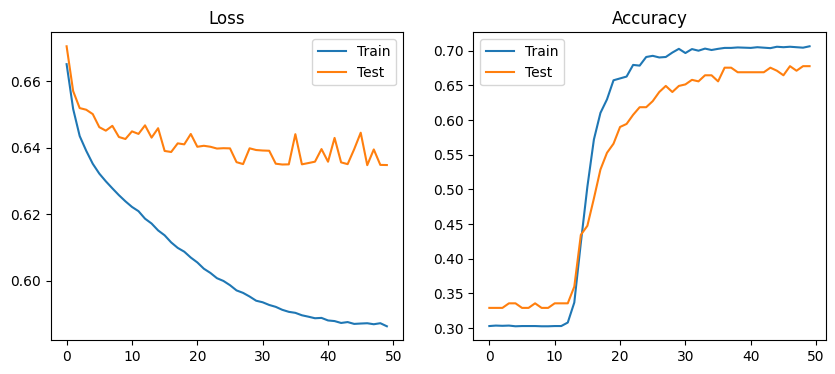

In [104]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(history.get("train_loss"), label='Train')
plt.plot(history.get("test_loss"), label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.get("train_acc"), label='Train')
plt.plot(history.get("test_acc"), label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

### With augmentation

In [105]:
BATCH_SIZE = 16
EPOCHS = 50
LOSS_FN = nn.BCEWithLogitsLoss()
LEARNING_RATE = 1e-5

dataloader_train = DataLoader(train_aug_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

m = None
m = CNN(in_channel=1, out_channel=4).to(DEVICE)
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=1e-2)
scheduler = None
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

In [106]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "aug_cnn.pt"])
history_path = os.path.join(*[DATA_PATH, "saved_models", "aug_cnn_history.pkl"])
m = m.to(DEVICE)
if TRAIN:
  history = train(m, dataloader_train, dataloader_test, optimizer, LOSS_FN,
                  EPOCHS, DEVICE, scheduler=scheduler)
  torch.save(m.state_dict(), model_path)
  pickle.dump(history, open(history_path, "wb"))
else:
  m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
  history = pickle.load(open(history_path, "rb"))

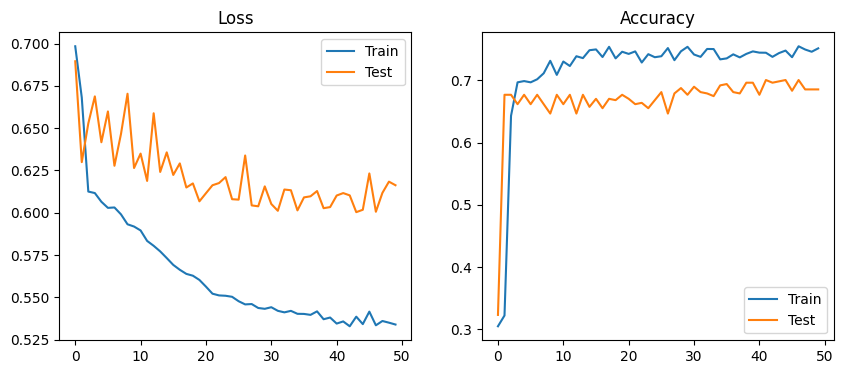

In [107]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(history.get("train_loss"), label='Train')
plt.plot(history.get("test_loss"), label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.get("train_acc"), label='Train')
plt.plot(history.get("test_acc"), label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

## EfficientNet

In [108]:
from torchvision.models import efficientnet_b0

In [109]:
def get_eff_net():
  m = None
  m = efficientnet_b0(weights=None)

  # Change to one output class
  m.classifier = nn.Sequential(
      nn.Dropout(p=0.4, inplace=True),
      nn.Linear(in_features=1280, out_features=1, bias=True),
  )

  # Change to one input channel
  m.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

  return m

In [110]:
summary(
    model=get_eff_net(),
    input_size=(32, 1, 105, 127),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 1, 105, 127]    [32, 1]              --                   True
├─Sequential (features)                                      [32, 1, 105, 127]    [32, 1280, 4, 4]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 1, 105, 127]    [32, 32, 53, 64]     --                   True
│    │    └─Conv2d (0)                                       [32, 1, 105, 127]    [32, 32, 53, 64]     288                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 53, 64]     [32, 32, 53, 64]     64                   True
│    │    └─SiLU (2)                                         [32, 32, 53, 64]     [32, 32, 53, 64]     --                   --
│    └─Sequential (1)                                        [32, 32, 53, 64]     [32, 16, 53,

In [111]:
BATCH_SIZE = 8
EPOCHS = 30
LOSS_FN = nn.BCEWithLogitsLoss()
LEARNING_RATE = 1e-6

dataloader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

m = get_eff_net()
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = None
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-9)

In [112]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "eff_net.pt"])
history_path = os.path.join(*[DATA_PATH, "saved_models", "eff_net_history.pkl"])
m = m.to(DEVICE)
if TRAIN:
  history = train(m, dataloader_train, dataloader_test, optimizer,
                  LOSS_FN, EPOCHS, DEVICE, scheduler=scheduler)
  torch.save(m.state_dict(), model_path)
  pickle.dump(history, open(history_path, "wb"))
else:
  m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
  history = pickle.load(open(history_path, "rb"))

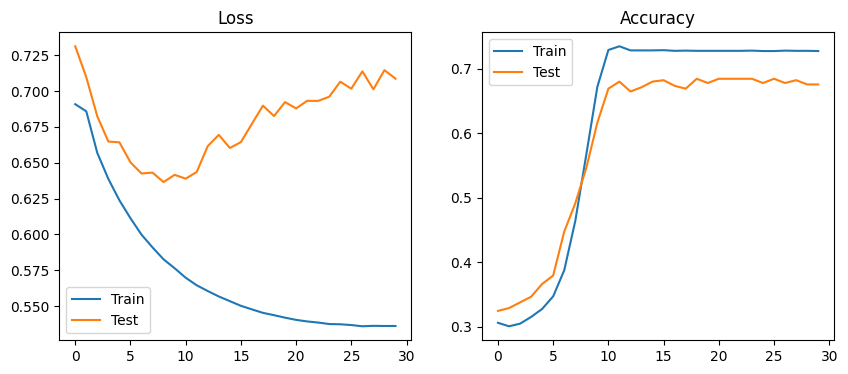

In [113]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(history.get("train_loss"), label='Train')
plt.plot(history.get("test_loss"), label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.get("train_acc"), label='Train')
plt.plot(history.get("test_acc"), label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

### With augmentation

In [114]:
BATCH_SIZE = 16
EPOCHS = 30
LOSS_FN = nn.BCEWithLogitsLoss()
LEARNING_RATE = 1e-5

dataloader_train = DataLoader(train_aug_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

m = get_eff_net()
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = None
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

In [115]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "aug_eff_net.pt"])
history_path = os.path.join(*[DATA_PATH, "saved_models", "aug_eff_net_history.pkl"])
m = m.to(DEVICE)
if TRAIN:
  history = train(m, dataloader_train, dataloader_test, optimizer,
                  LOSS_FN, EPOCHS, DEVICE, scheduler=scheduler)
  torch.save(m.state_dict(), model_path)
  pickle.dump(history, open(history_path, "wb"))
else:
  m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
  history = pickle.load(open(history_path, "rb"))

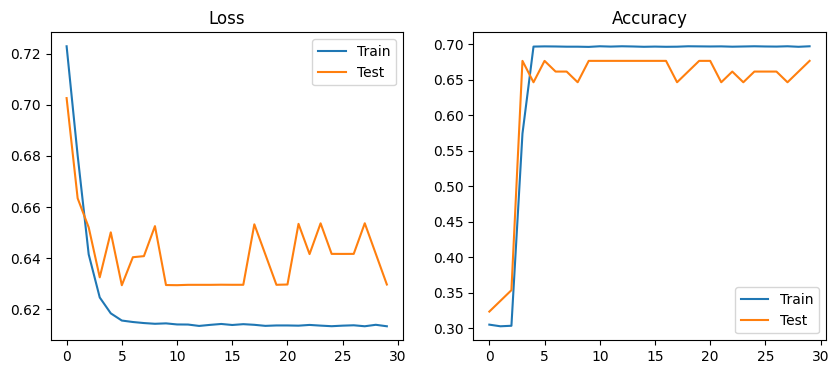

In [116]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(history.get("train_loss"), label='Train')
plt.plot(history.get("test_loss"), label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.get("train_acc"), label='Train')
plt.plot(history.get("test_acc"), label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

## ResNet

In [117]:
from torchvision.models import resnet50

In [118]:
def get_res_net():
    m = None
    m = resnet50(weights=None)

    # Change to one input channel
    m.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)

    # Change to one output class
    m.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

    return m

In [119]:
summary(
    model=get_res_net(),
    input_size=(32, 1, 105, 127),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 1, 105, 127]    [32, 1]              --                   True
├─Conv2d (conv1)                         [32, 1, 105, 127]    [32, 64, 53, 64]     3,136                True
├─BatchNorm2d (bn1)                      [32, 64, 53, 64]     [32, 64, 53, 64]     128                  True
├─ReLU (relu)                            [32, 64, 53, 64]     [32, 64, 53, 64]     --                   --
├─MaxPool2d (maxpool)                    [32, 64, 53, 64]     [32, 64, 27, 32]     --                   --
├─Sequential (layer1)                    [32, 64, 27, 32]     [32, 256, 27, 32]    --                   True
│    └─Bottleneck (0)                    [32, 64, 27, 32]     [32, 256, 27, 32]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 27, 32]     [32, 64, 27, 32]     4,096                True
│    │    └─BatchN

In [120]:
BATCH_SIZE = 8
EPOCHS = 30
LOSS_FN = nn.BCEWithLogitsLoss()
LEARNING_RATE = 1e-7

dataloader_train = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

m = get_res_net()
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = None
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-9)

In [121]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "res_net.pt"])
history_path = os.path.join(*[DATA_PATH, "saved_models", "res_net_history.pkl"])
m = m.to(DEVICE)
if TRAIN:
  history = train(m, dataloader_train, dataloader_test, optimizer,
                  LOSS_FN, EPOCHS, DEVICE, scheduler=scheduler)
  torch.save(m.state_dict(), model_path)
  pickle.dump(history, open(history_path, "wb"))
else:
  m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
  history = pickle.load(open(history_path, "rb"))

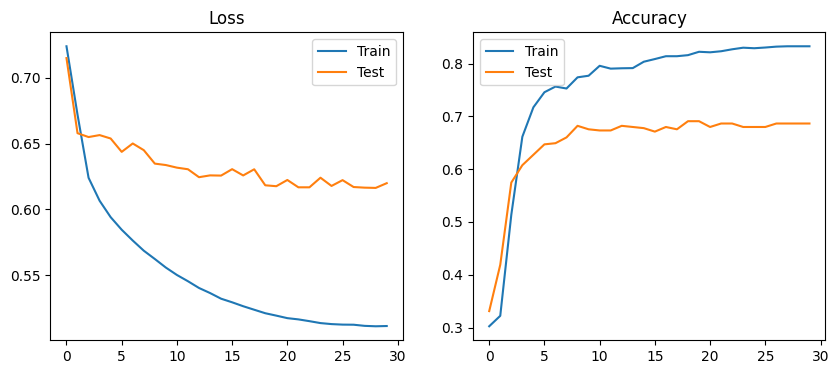

In [122]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(history.get("train_loss"), label='Train')
plt.plot(history.get("test_loss"), label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.get("train_acc"), label='Train')
plt.plot(history.get("test_acc"), label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

### With augmentation

In [123]:
BATCH_SIZE = 8
EPOCHS = 30
LOSS_FN = nn.BCEWithLogitsLoss()
LEARNING_RATE = 1e-7

dataloader_train = DataLoader(train_aug_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dataloader_test = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

m = get_res_net()
optimizer = torch.optim.Adam(m.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = None
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-9)

In [124]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "aug_res_net.pt"])
history_path = os.path.join(*[DATA_PATH, "saved_models", "aug_res_net_history.pkl"])
m = m.to(DEVICE)
if TRAIN:
  history = train(m, dataloader_train, dataloader_test, optimizer,
                  LOSS_FN, EPOCHS, DEVICE, scheduler=scheduler)
  torch.save(m.state_dict(), model_path)
  pickle.dump(history, open(history_path, "wb"))
else:
  m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))
  history = pickle.load(open(history_path, "rb"))

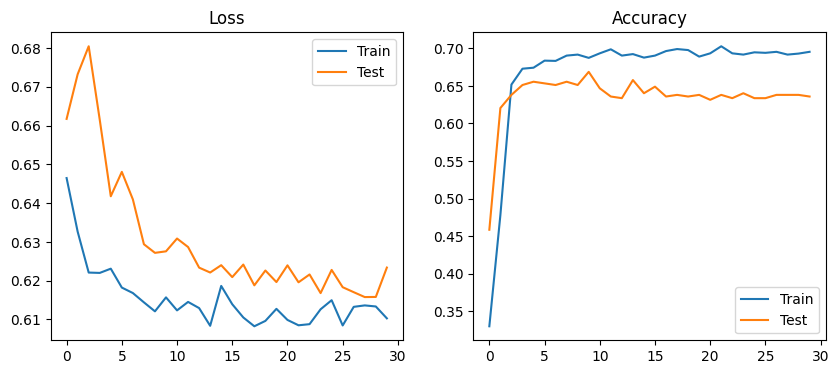

In [125]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1)
plt.plot(history.get("train_loss"), label='Train')
plt.plot(history.get("test_loss"), label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history.get("train_acc"), label='Train')
plt.plot(history.get("test_acc"), label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

# **Results**: Metric Evaluation, GradCAM

## Metrics Evaluation

In [126]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

In [127]:
def pred(model, data_loader, device):
  model.eval()

  with torch.inference_mode():

    predictions = torch.Tensor().to(DEVICE)
    labels = torch.Tensor().to(DEVICE)

    for batch, (X, y) in enumerate(data_loader):

      # Send data to device
      X, y = X.to(device), y.type(torch.float32).to(device)

      labels = torch.cat((labels, y), 0)

      # Forward pass
      test_pred = model(X)
      test_pred = test_pred.squeeze()

      # Clean Cache
      torch.cuda.empty_cache()

      predictions = torch.cat((predictions, test_pred), 0)

  return (predictions.flatten() > 0.5).int().cpu(), (labels.flatten()).int().cpu()

### Basic CNN

In [128]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "cnn.pt"])
cnn_m = CNN(in_channel=1, out_channel=4).to(DEVICE)
cnn_m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))

preds_cnn, labels = pred(cnn_m, dataloader_test, DEVICE)

In [129]:
confusion_matrix(labels, preds_cnn)

array([[ 60,  90],
       [ 42, 258]])

In [130]:
print(f"Recall --> {recall_score(labels, preds_cnn)}")
print(f"Precision --> {precision_score(labels, preds_cnn)}")
print(f"F1 --> {f1_score(labels, preds_cnn)}")

Recall --> 0.86
Precision --> 0.7413793103448276
F1 --> 0.7962962962962963


### EfficientNet

In [131]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "eff_net.pt"])
eff_m = get_eff_net().to(DEVICE)
eff_m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))

preds_eff, labels = pred(eff_m, dataloader_test, DEVICE)

In [132]:
confusion_matrix(labels, preds_eff)

array([[ 30, 120],
       [  0, 300]])

In [133]:
print(f"Recall --> {recall_score(labels, preds_eff)}")
print(f"Precision --> {precision_score(labels, preds_eff)}")
print(f"F1 --> {f1_score(labels, preds_eff)}")

Recall --> 1.0
Precision --> 0.7142857142857143
F1 --> 0.8333333333333333


### ResNet

In [134]:
model_path = os.path.join(*[DATA_PATH, "saved_models", "res_net.pt"])
res_m = get_res_net().to(DEVICE)
res_m.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))

preds_res, labels = pred(res_m, dataloader_test, DEVICE)

In [135]:
confusion_matrix(labels, preds_res)

array([[ 78,  72],
       [ 21, 279]])

In [136]:
print(f"Recall --> {recall_score(labels, preds_res)}")
print(f"Precision --> {precision_score(labels, preds_res)}")
print(f"F1 --> {f1_score(labels, preds_res)}")

Recall --> 0.93
Precision --> 0.7948717948717948
F1 --> 0.8571428571428572


## GradCAM

In [144]:
%%capture
! pip install grad-cam

In [145]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [146]:
def get_grad_cam(m, idx, target_l, preds):
  # Choose instance from test set
  image, label = test_ds[idx]
  image = image.unsqueeze(0).to(DEVICE)
  image.size()

  # Fix img dimensions
  im = image.squeeze(0).cpu()
  image_rgb = np.transpose(np.stack((im, im, im), axis=1).squeeze(), (1,2,0))

  # Apply GradCAM
  cam = GradCAM(model=m, target_layers=target_l)
  grey_scale_cam = cam(input_tensor=image, targets=None)
  visualization = show_cam_on_image(image_rgb, grey_scale_cam[0, :], use_rgb=True)

  return visualization

In [147]:
def plot_cam(t_layers, model, preds):
    plt.figure(figsize=(20, 6))
    sp_num = 0
    for i in range(0, len(test_ds)):
        if sp_num > 4:
            break

        if int(preds[i]) == labels[i]:
            viz = get_grad_cam(model, i, t_layers, preds)

            sp_num += 1
            plt.subplot(1, 5, sp_num)
            plt.title(f"GT: {preds[i]} - Pred: {labels[i]}")
            plt.imshow(viz)

### Basic CNN

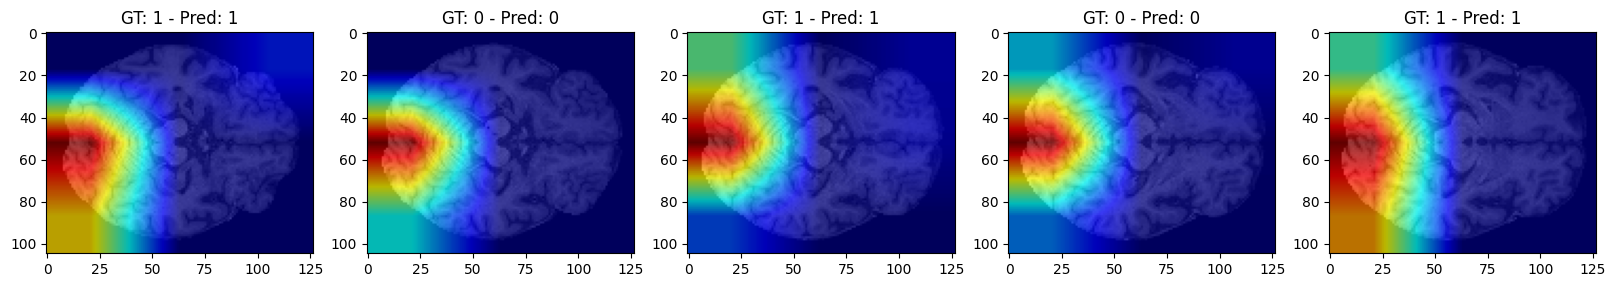

In [148]:
target_layers = [cnn_m.model[5].conv_2d, cnn_m.model[5].batch_norm, cnn_m.model[5].relu]

plot_cam(target_layers, cnn_m, preds_cnn)

### EfficientNet

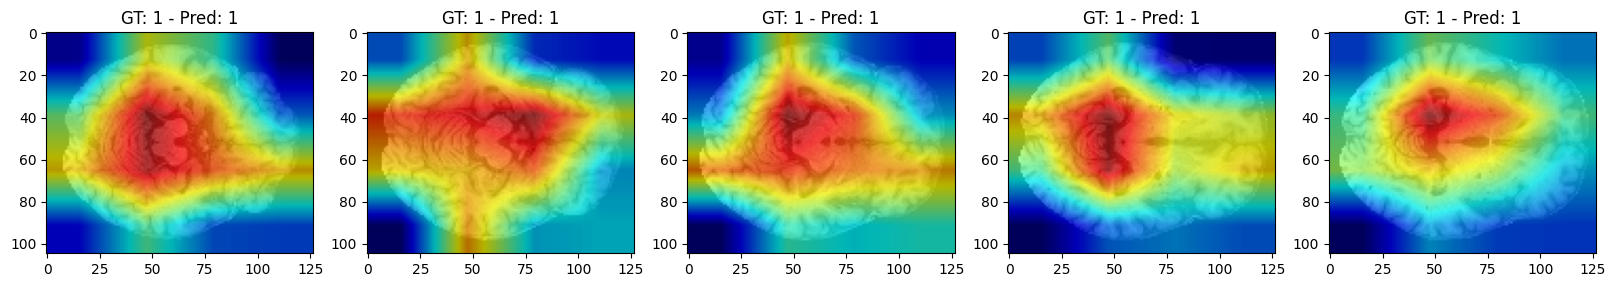

In [149]:
target_layers = [eff_m.features[-1]]

plot_cam(target_layers, eff_m, preds_eff)

### ResNet

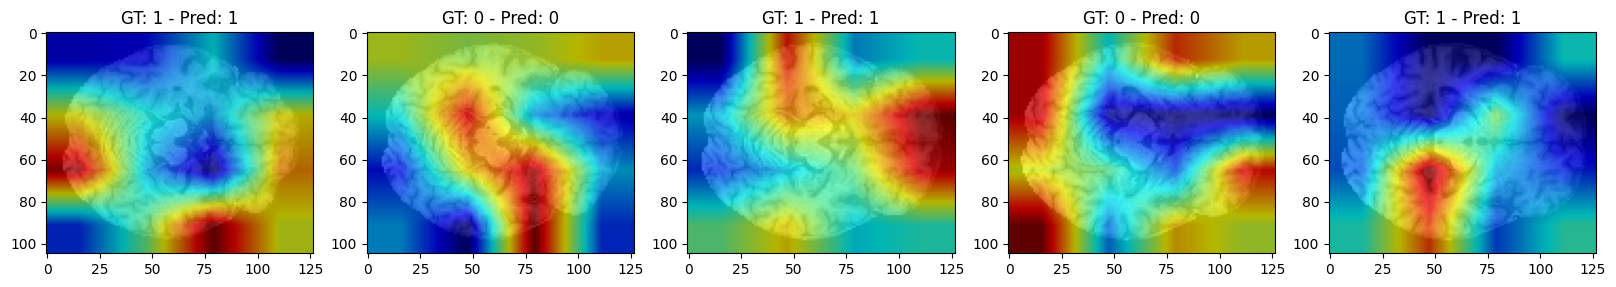

In [150]:
target_layers = [res_m.layer4[-1]]

plot_cam(target_layers, res_m, preds_res)